## Signal Processing

Opensoundscape provides a set of signal processing tools developed in house. In this notebook we provide a comparison of two of these tools on a published bioacoustics dataset.

* RIBBIT (Repeat-Interval Based Bioacoustic Identification Tool) is a tool for detecting vocalizations that have a repeating structure. This tool is useful for detecting vocalizations of frogs, toads, and other animals that produce vocalizations with a periodic structure. 

    ref: [Automated detection of frog calls and choruses by pulse repetition rate](https://doi.org/10.1111/cobi.13718)
    
* Continuous wavelet transform

    ref: In Review. Automated recognition of Ruffed Grouse drumming in field recordings. Wildlife Society Bulletin.

### Import required packages

In [1]:
# Data handling and plotting
import pandas as pd
from pathlib import Path
import IPython.display as ipd
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [16,8] # spectrogram / figure size - adjust for your display

# Audio handling
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram

# Signal processing
from opensoundscape.ribbit import ribbit
from opensoundscape.signal_processing import detect_peak_sequence_cwt

### Dataset

We choose one particular bird species Northern Flicker (Colaptes auratus) that has a song conducive to analysis by the signal processing methods. The sample clips for this analysis have already been provided been with the repository in the `data` folder.

In [2]:
# set the data path

data_path = './data/'

Let us look at a particular type of song called 'keek' for this species which has a repeating sequence of shrill calls. The clip used to get a good idea of the song has been downloaded from [xeno-canto](https://xeno-canto.org), a website for sharing crowd-sourced recordings of wildlife sounds from all across the world.

The particular clip `XC645833 - Northern Flicker - Colaptes auratus.mp3` is from Ted Floyd, XC645833. Accessible at www.xeno-canto.org/645833.

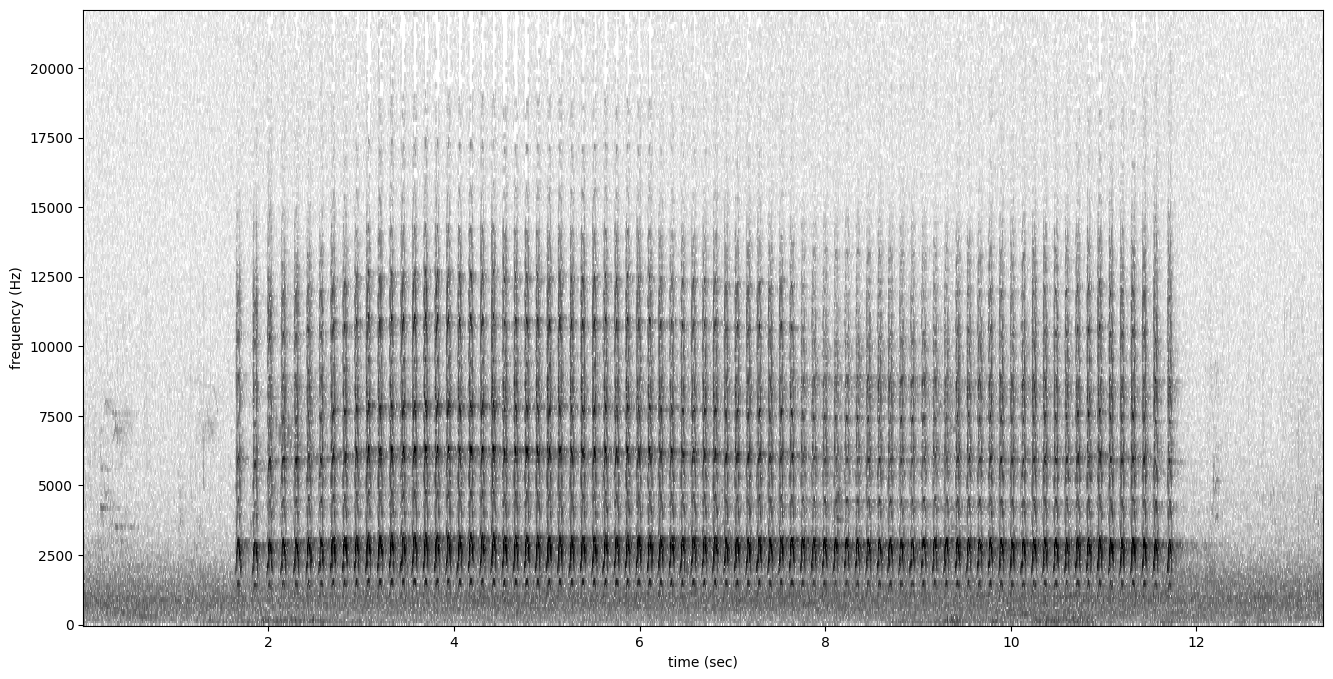

In [3]:
# load audio file and display it
nofl_keek_audio_xc = Audio.from_file(data_path + 'clips/XC645833 - Northern Flicker - Colaptes auratus.mp3')
ipd.display(ipd.Audio(nofl_keek_audio_xc.samples, rate=nofl_keek_audio_xc.sample_rate))

# Spectrogram
Spectrogram.from_audio(nofl_keek_audio_xc).plot()

For the analysis we utilize a bioacoustics dataset published by the Kitzes Lab, of Eastern North American birds, which comprises of 385 minutes of dawn chorus soundscapes for 48 species collected in the Northeastern United States at Powdermill Nature Reserve, Rector, Pennsylvania, USA through autonomous acoustic recorders between the months of April through July 2018. Each of the soundscape recording in this dataset is divided into five minutes long annotated segments. 

ref: [Chronister LM, Rhinehart TA, Place A, Kitzes J. An annotated set of audio recordings of Eastern North American birds containing frequency, time, and species information. Ecology. 2021 Jun;102(6):e03329. doi: 10.1002/ecy.3329. Epub 2021 May 11. PMID: 33705568.](https://esajournals.onlinelibrary.wiley.com/doi/full/10.1002/ecy.3329)

We choose four of this segments for our analysis since they are labeled to contain the most number of NOFL calls. The corresponding Raven annotations have been loaded and filtered using OpSo `annotations` module as described in another demo notebook, and only the records of interest have been retained as part of the csv files in the `data` folder.

In [4]:
# load annotations
nofl_keek_df = pd.read_csv(data_path+'nofl_keek_df.csv')
nofl_keek_df

clip  start_time    end_time   low_f  high_f call_type
0   Recording_1_Segment_23   17.219173   19.750294  2482.6  3499.1      keek
1   Recording_1_Segment_23  100.463319  104.715601  2595.3  3570.9      keek
2   Recording_1_Segment_23  122.952207  126.447564  2397.6  3399.9      keek
3   Recording_1_Segment_29  138.433920  148.429374  2032.4  3221.2      keek
4   Recording_1_Segment_29  169.157987  178.007986  2070.8  3144.5      keek
5   Recording_1_Segment_29  205.926584  213.406129  2090.0  4064.9      keek
6   Recording_1_Segment_29  249.811498  255.470589  1840.7  3585.5      keek
7   Recording_1_Segment_29  284.270849  289.425394  2032.4  3317.1      keek
8   Recording_2_Segment_09  206.497758  211.574463  2033.4  3432.5      keek
9   Recording_2_Segment_09  234.100365  237.841602  2294.5  3488.5      keek
10  Recording_2_Segment_09  258.388578  263.161548  2126.6  3469.8      keek
11  Recording_2_Segment_09  278.715166  282.620323  1846.8  3451.1      keek
12  Recording_4_Segment_21   92.210881   95.088153  1096.5  1774.4      keek
13  Recording_4_Segment_21  200.621334  202.561107  1056.6  3289.6      keek
14  Recording_4_Segment_21  254.053976  256.531137  1016.8  2044.6      keek

Above annotations have then been one-hot encoded for the entire segments.

In [5]:
# load clip time dataframe
nofl_keek_labels_df = pd.read_csv(data_path+'nofl_keek_labels_df.csv')
nofl_keek_labels_df

file  start_time  end_time  label
0    ./data/clips/Recording_1_Segment_23.mp3         0.0      10.0    0.0
1    ./data/clips/Recording_1_Segment_23.mp3        10.0      20.0    1.0
2    ./data/clips/Recording_1_Segment_23.mp3        20.0      30.0    0.0
3    ./data/clips/Recording_1_Segment_23.mp3        30.0      40.0    0.0
4    ./data/clips/Recording_1_Segment_23.mp3        40.0      50.0    0.0
..                                       ...         ...       ...    ...
115  ./data/clips/Recording_4_Segment_21.mp3       250.0     260.0    1.0
116  ./data/clips/Recording_4_Segment_21.mp3       260.0     270.0    0.0
117  ./data/clips/Recording_4_Segment_21.mp3       270.0     280.0    0.0
118  ./data/clips/Recording_4_Segment_21.mp3       280.0     290.0    0.0
119  ./data/clips/Recording_4_Segment_21.mp3       290.0     300.0    0.0

[120 rows x 4 columns]

Let us look at one of the positive clips to see the bird call in real-time environment.

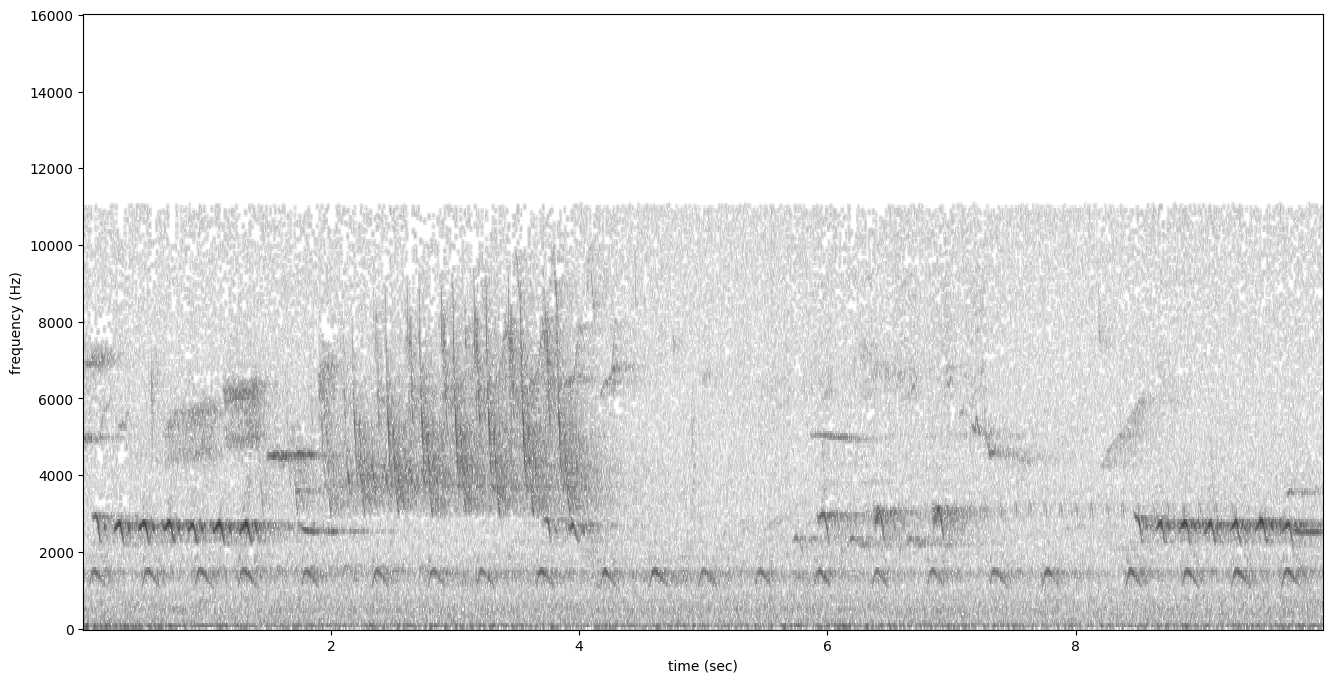

In [6]:
# audio
audio = Audio.from_file(nofl_keek_labels_df.at[1, 'file'], offset=nofl_keek_labels_df.at[1,'start_time'], duration=nofl_keek_labels_df.at[1, 'end_time']-nofl_keek_labels_df.at[1,'start_time'])

ipd.display(ipd.Audio(audio.samples, rate=audio.sample_rate))
Spectrogram.from_audio(audio).plot()

It seems to be different from the pristine xeno-canto recording, less loud and is interspersed with other calls. Would be interesting to see if our signal processing methods can capture the nuances.

### RIBBIT
This method detects sounds with periodic amplitude modulation.

#### Modal parameters

The method requires signal parameters to be set based on expected properties of the call as following.

In [7]:
# minimum and maximum rate of pulsing (pulses per second) to search for
pulse_rate_range = [5,15] 

# look for a vocalization in the frequency range  
signal_band = [1000,20000] 

# subtract the amplitude signal from these frequency ranges
noise_bands = None

# divides the signal into segments this many seconds long, analyzes each independently
clip_duration = 4 # seconds
clip_overlap = 0 # seconds
final_clip = 'remainder' # how to handle the final clip if it is shorter than clip_duration

# if True, it will show the power spectrum plot for each audio segment 
show_plots = True 

#### Run + Analysis
To start with, we analyze the single xeno-canto file with parameters set for the same.

window: 0.0 to 4.0 sec


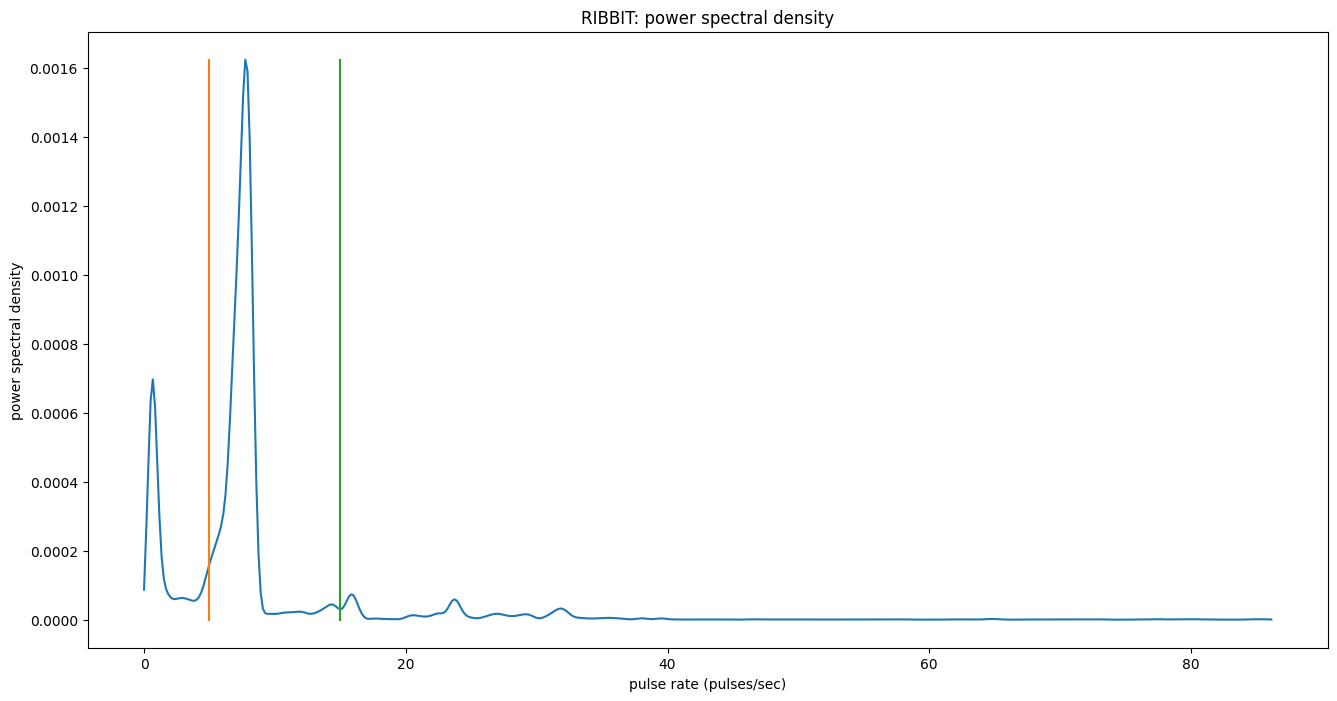

window: 4.0 to 8.0 sec


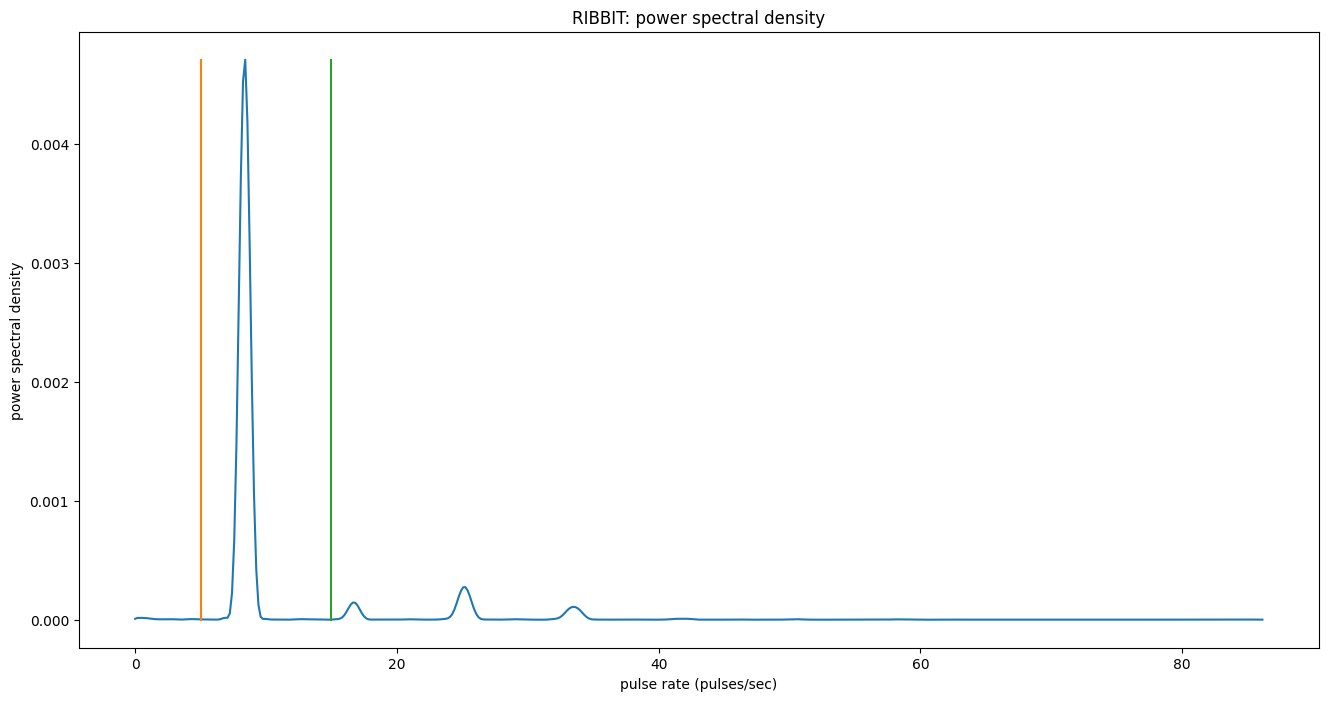

window: 8.0 to 12.0 sec


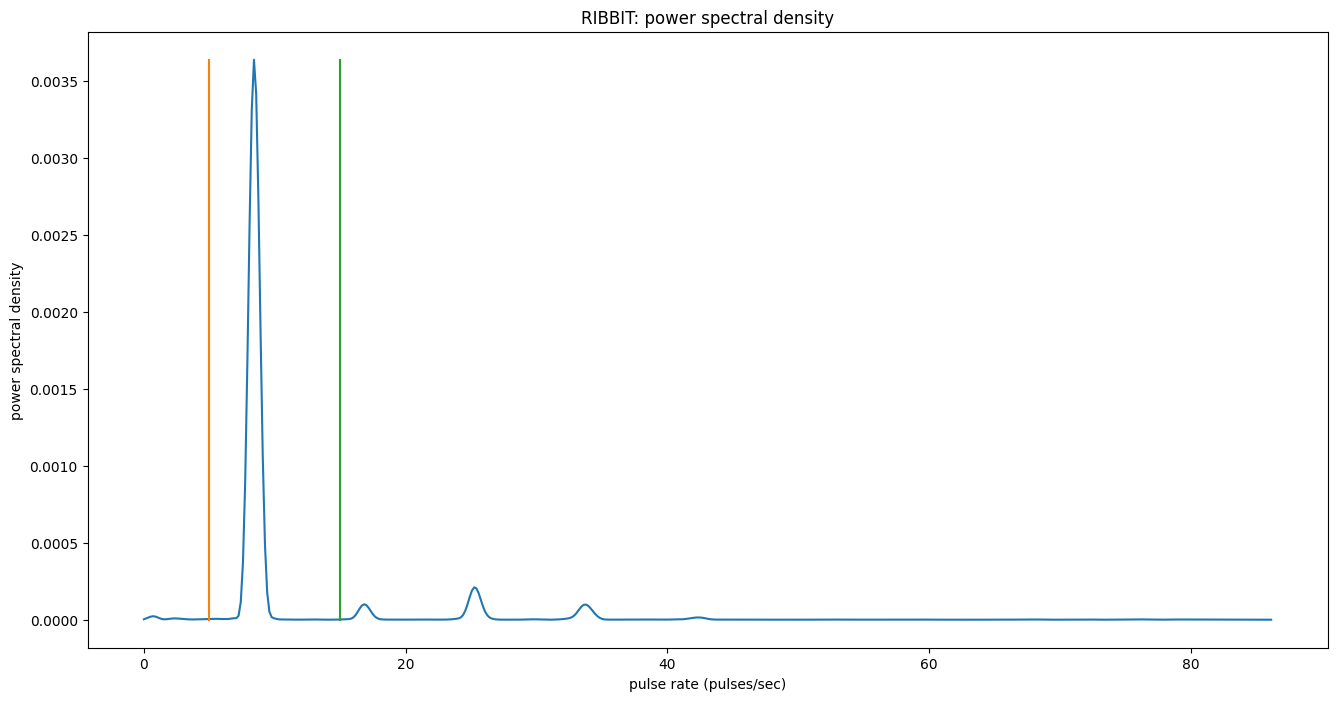

window: 12.0 to 13.3688888889 sec


/Users/jk/opt/anaconda3/envs/opso/lib/python3.9/site-packages/scipy/signal/_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 235, using nperseg = 235
  warnings.warn('nperseg = {0:d} is greater than input length '


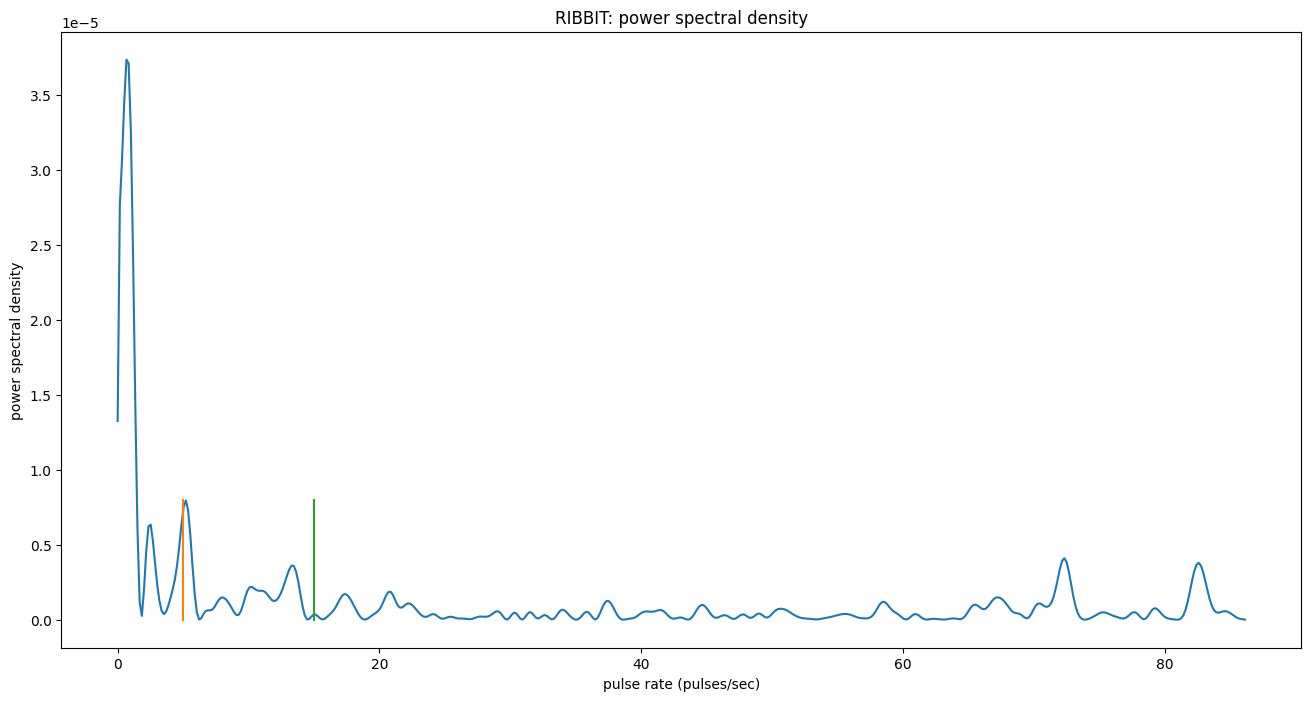

start_time   end_time      score
0         0.0   4.000000  16.241474
1         4.0   8.000000  47.065191
2         8.0  12.000000  36.379828
3        12.0  13.368889   0.079604

In [8]:
# make the spectrogram
spec = Spectrogram.from_audio(nofl_keek_audio_xc)

#run RIBBIT
score_df =  ribbit(
                    spectrogram=spec,
                    signal_band=signal_band,
                    pulse_rate_range=pulse_rate_range,
                    clip_duration=clip_duration,
                    clip_overlap=clip_overlap,
                    noise_bands=noise_bands,
                    final_clip=final_clip,
                    plot=show_plots,
                )

score_df['score'] = score_df['score']*10000
score_df

RIBBIT scores for each of the clip sections but the last one as shown above are high as they are directly proportional to the power spectral density in the provided pulse rate range showcased in each of the clip plots.

#### Evaluation

Now, let us look at the field clips we have from the PNRE dataset. We change the parameters a bit for the same since the segments are longer here.

In [9]:
clip_duration = 10 # seconds
show_plots = False # not show plots for each of the 10 second clips on long segments

In [10]:
score_df_list = []

# calculate RIBBIT scores
for file in nofl_keek_labels_df['file'].unique():
    
    # make the spectrogram
    spec = Spectrogram.from_audio(audio.from_file(file))

    #run RIBBIT
    score_df =  ribbit(
                        spectrogram=spec,
                        signal_band=signal_band,
                        pulse_rate_range=pulse_rate_range,
                        clip_duration=clip_duration,
                        clip_overlap=clip_overlap,
                        noise_bands=noise_bands,
                        final_clip=final_clip,
                        plot=show_plots,
                        )
    
    score_df['score'] = score_df['score']*10000
    score_df['file'] = file
    score_df = score_df.reset_index(drop=True).set_index(['file', 'start_time', 'end_time'])
    
    score_df_list.append(score_df)

score_df = pd.concat(score_df_list).sort_index()
score_df

score
file                                    start_time end_time          
./data/clips/Recording_1_Segment_23.mp3 0.0        10.0      0.043261
                                        10.0       20.0      0.047610
                                        20.0       30.0      0.033506
                                        30.0       40.0      0.041690
                                        40.0       50.0      0.038888
...                                                               ...
./data/clips/Recording_4_Segment_21.mp3 250.0      260.0     0.054558
                                        260.0      270.0     0.031427
                                        270.0      280.0     0.052427
                                        280.0      290.0     0.035579
                                        290.0      300.0     0.156461

[120 rows x 1 columns]

In [11]:
# files sorted by score, from highest to lowest
results_df = nofl_keek_labels_df.reset_index(drop=True).set_index(['file', 'start_time', 'end_time']).join(score_df)
results_df.sort_values(by='score',ascending=False)

label     score
file                                    start_time end_time                 
./data/clips/Recording_1_Segment_29.mp3 170.0      180.0       1.0  1.745413
                                        140.0      150.0       1.0  0.887273
                                        210.0      220.0       1.0  0.871084
                                        280.0      290.0       1.0  0.717441
                                        250.0      260.0       1.0  0.569501
...                                                            ...       ...
./data/clips/Recording_1_Segment_23.mp3 270.0      280.0       0.0  0.015673
./data/clips/Recording_1_Segment_29.mp3 70.0       80.0        0.0  0.015086
                                        120.0      130.0       0.0  0.013659
                                        290.0      300.0       0.0  0.012920
./data/clips/Recording_2_Segment_09.mp3 250.0      260.0       1.0  0.011475

[120 rows x 2 columns]

A visual inspection of the scores for each segment based on annotation would provide a better understanding of method's performance.

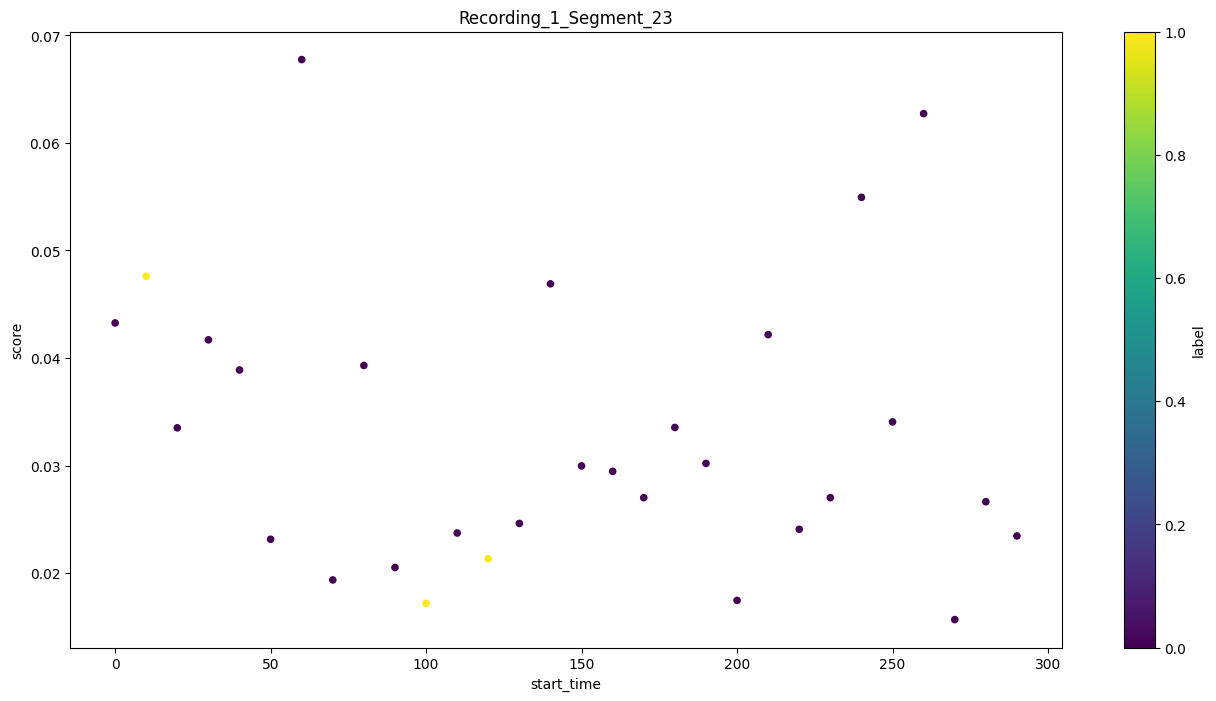

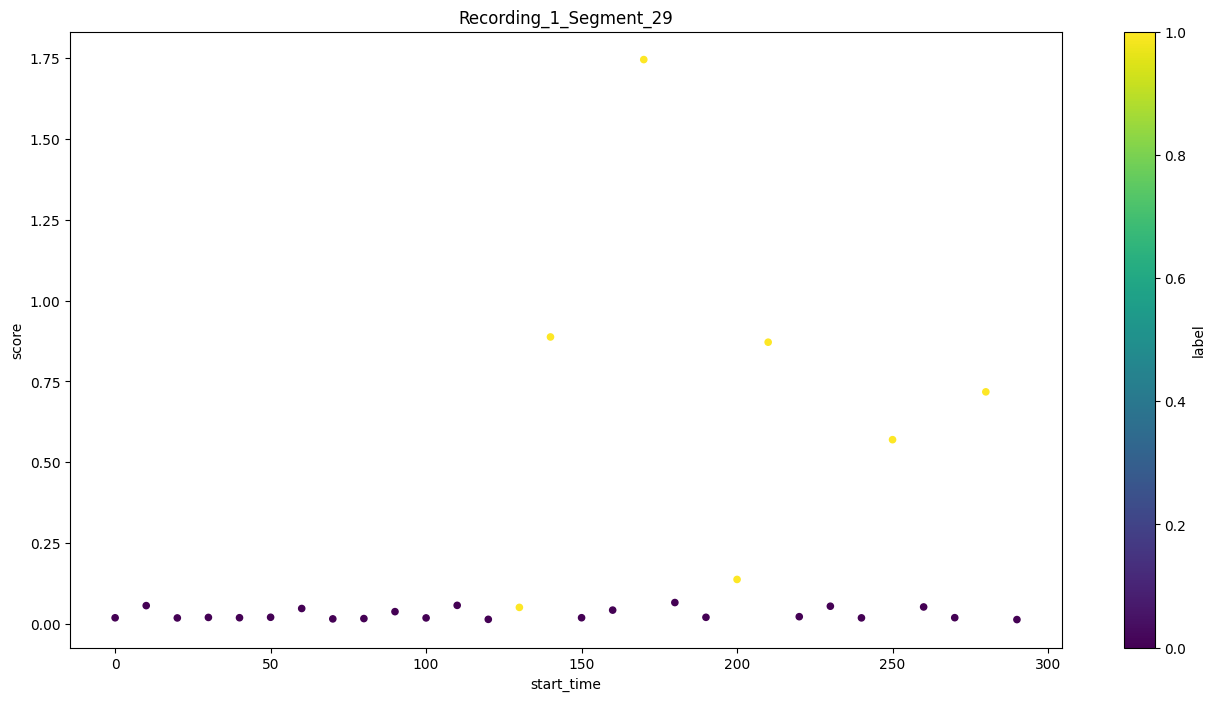

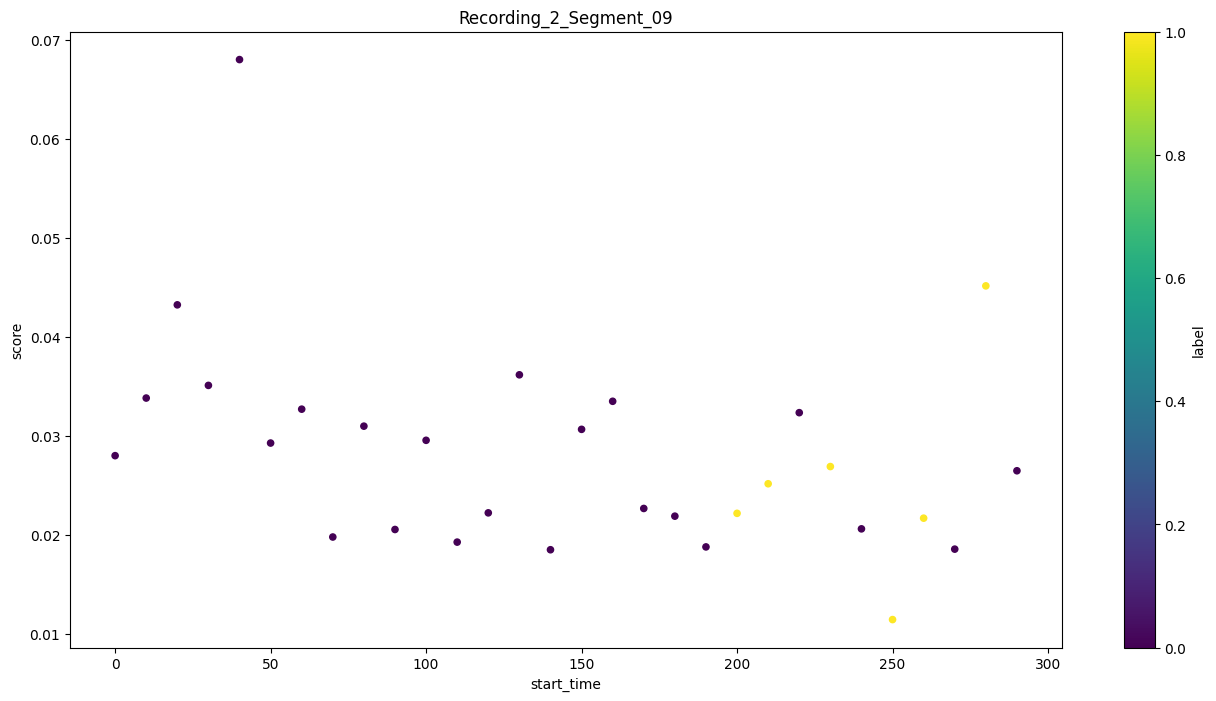

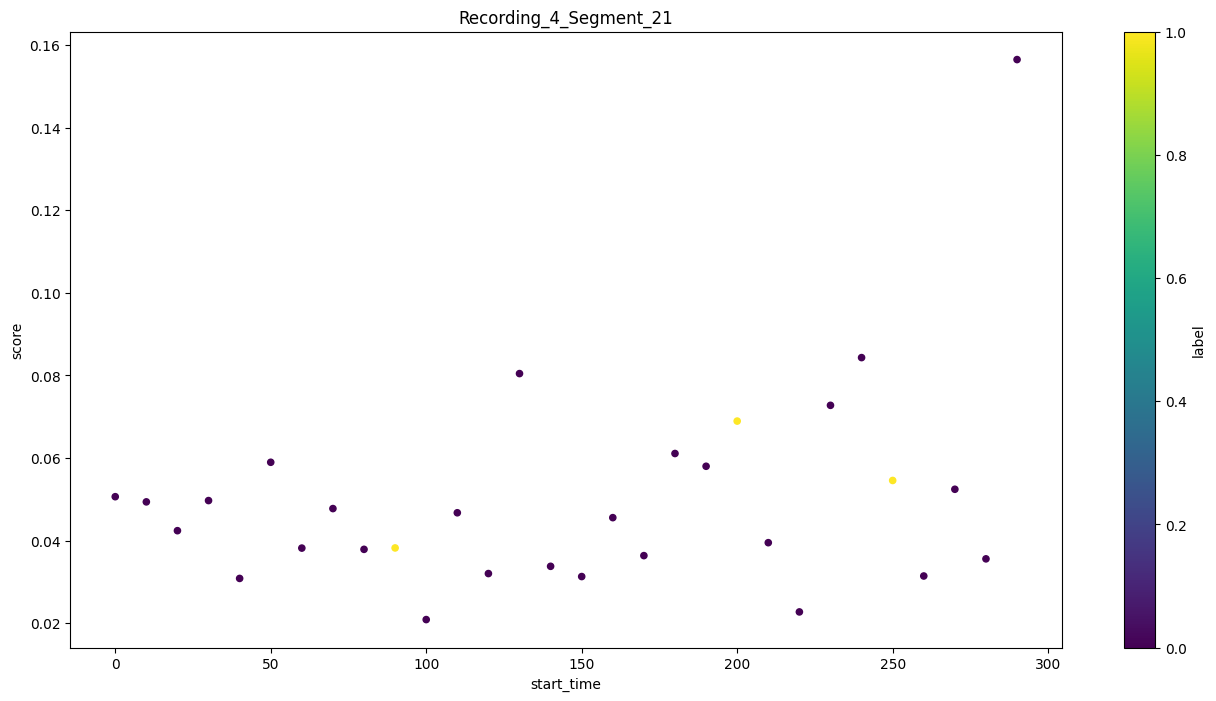

In [12]:
# Plots
results_df.reset_index(inplace=True)
for file in results_df['file'].unique():
    results_df[results_df['file']==file].plot.scatter(x='start_time', y='score', c='label', colormap='viridis', title=Path(file).stem)

As seen above, the tool only does well on one of the segments `Recording_1_Segment_29`. We would need to analyze the clips and tweak the parameters for the method to work better overall.

In [13]:
nofl_keek_df.describe()

start_time    end_time        low_f       high_f
count   15.000000   15.000000    15.000000    15.000000
mean   187.521573  192.335418  1934.200000  3250.240000
std     78.661865   78.869202   501.523131   585.019875
min     17.219173   19.750294  1016.800000  1774.400000
25%    130.693063  137.438469  1843.750000  3255.400000
50%    205.926584  211.574463  2033.400000  3432.500000
75%    251.932737  256.000863  2210.550000  3493.800000
max    284.270849  289.425394  2595.300000  4064.900000

In [14]:
# look for a vocalization in the frequency range of [min(low_f), max(high_f)]
signal_band = [800,4200]

In [15]:
score_df_list = []

# calculate RIBBIT scores
for file in nofl_keek_labels_df['file'].unique():
    
    # make the spectrogram
    spec = Spectrogram.from_audio(audio.from_file(file))

    #run RIBBIT
    score_df =  ribbit(
                        spectrogram=spec,
                        signal_band=signal_band,
                        pulse_rate_range=pulse_rate_range,
                        clip_duration=clip_duration,
                        clip_overlap=clip_overlap,
                        noise_bands=noise_bands,
                        final_clip=final_clip,
                        plot=show_plots,
                        )
    
    score_df['score'] = score_df['score']*10000
    score_df['file'] = file
    score_df = score_df.reset_index(drop=True).set_index(['file', 'start_time', 'end_time'])
    
    score_df_list.append(score_df)

score_df = pd.concat(score_df_list).sort_index()

# files sorted by score, from highest to lowest
results_df = nofl_keek_labels_df.reset_index(drop=True).set_index(['file', 'start_time', 'end_time']).join(score_df)
results_df.sort_values(by='score',ascending=False)
results_df

label     score
file                                    start_time end_time                 
./data/clips/Recording_1_Segment_23.mp3 0.0        10.0        0.0  0.151727
                                        10.0       20.0        1.0  0.420269
                                        20.0       30.0        0.0  0.222727
                                        30.0       40.0        0.0  0.200542
                                        40.0       50.0        0.0  0.120529
...                                                            ...       ...
./data/clips/Recording_4_Segment_21.mp3 250.0      260.0       1.0  0.394893
                                        260.0      270.0       0.0  0.089160
                                        270.0      280.0       0.0  0.109138
                                        280.0      290.0       0.0  0.179690
                                        290.0      300.0       0.0  0.591426

[120 rows x 2 columns]

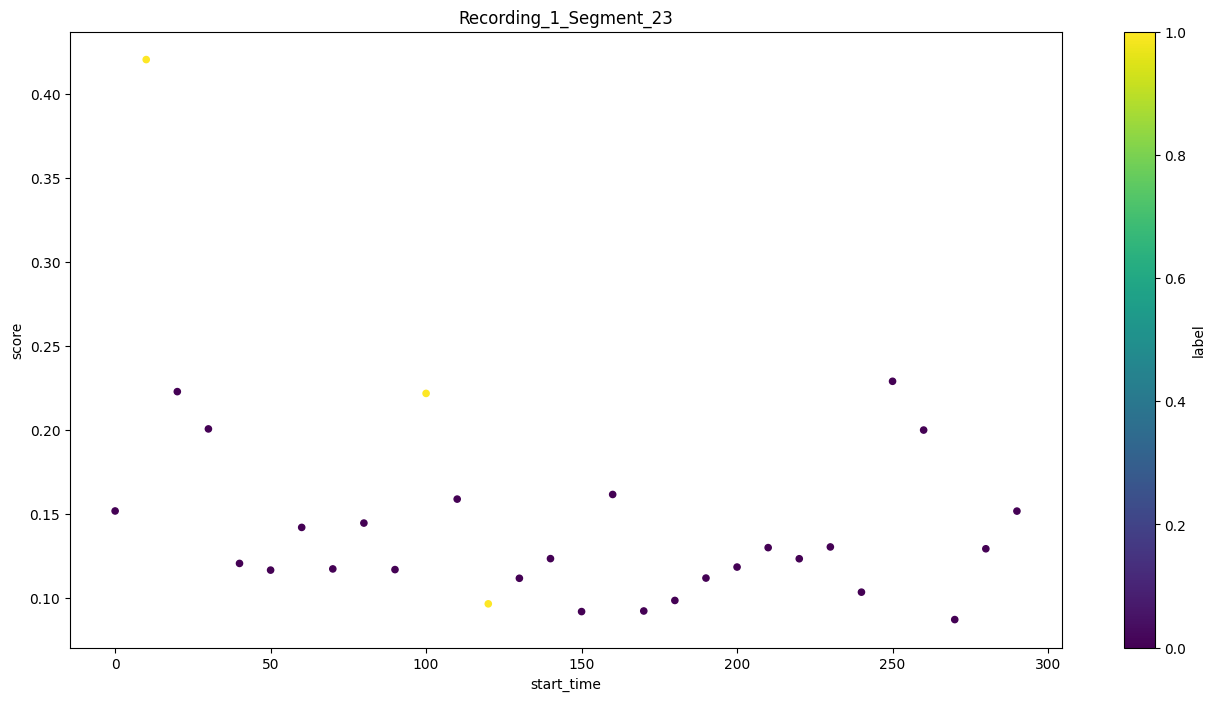

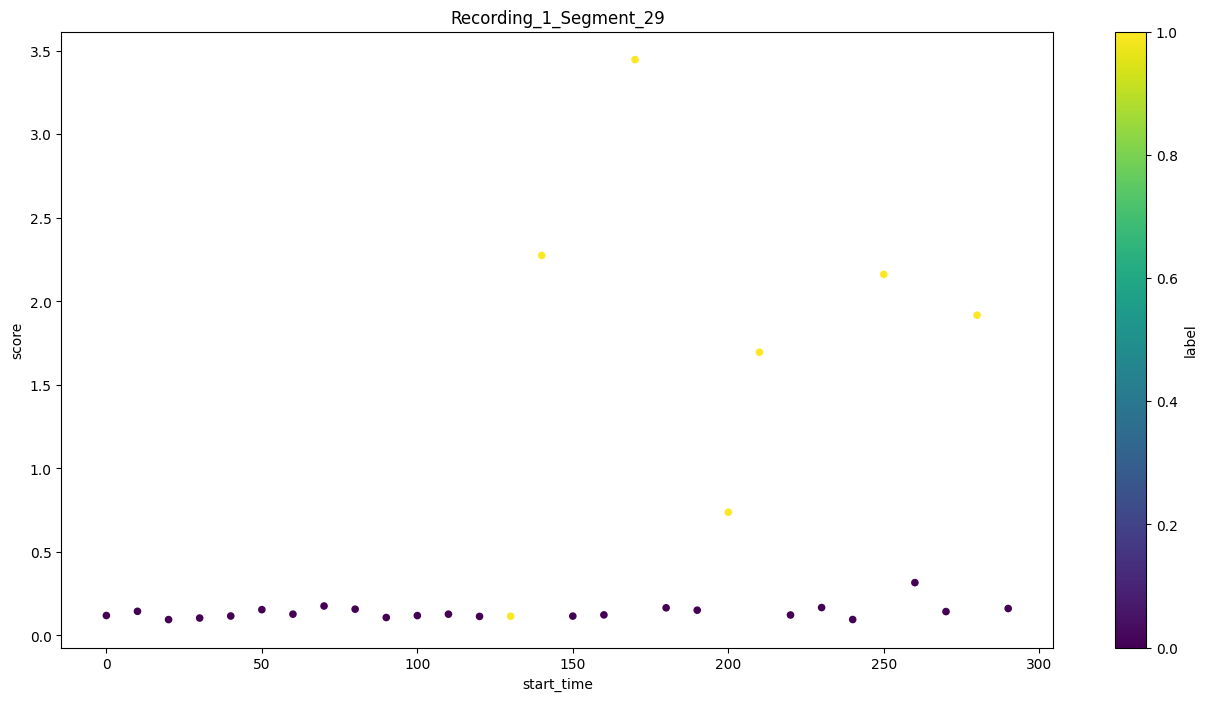

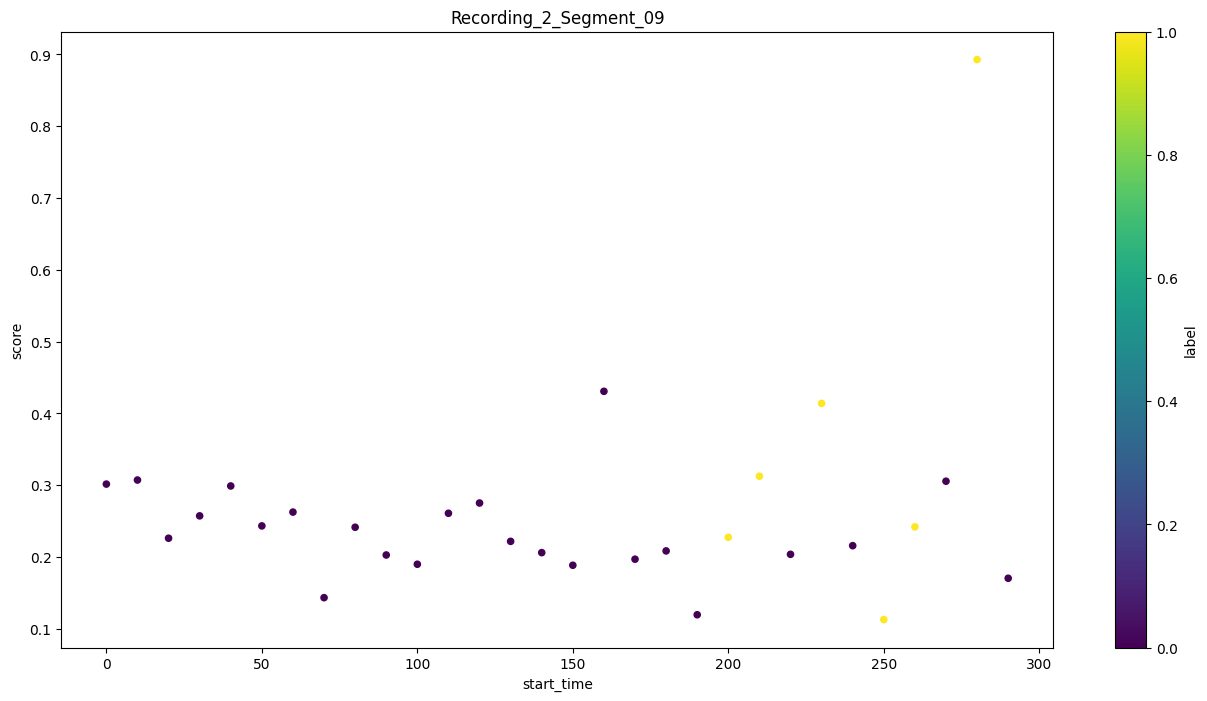

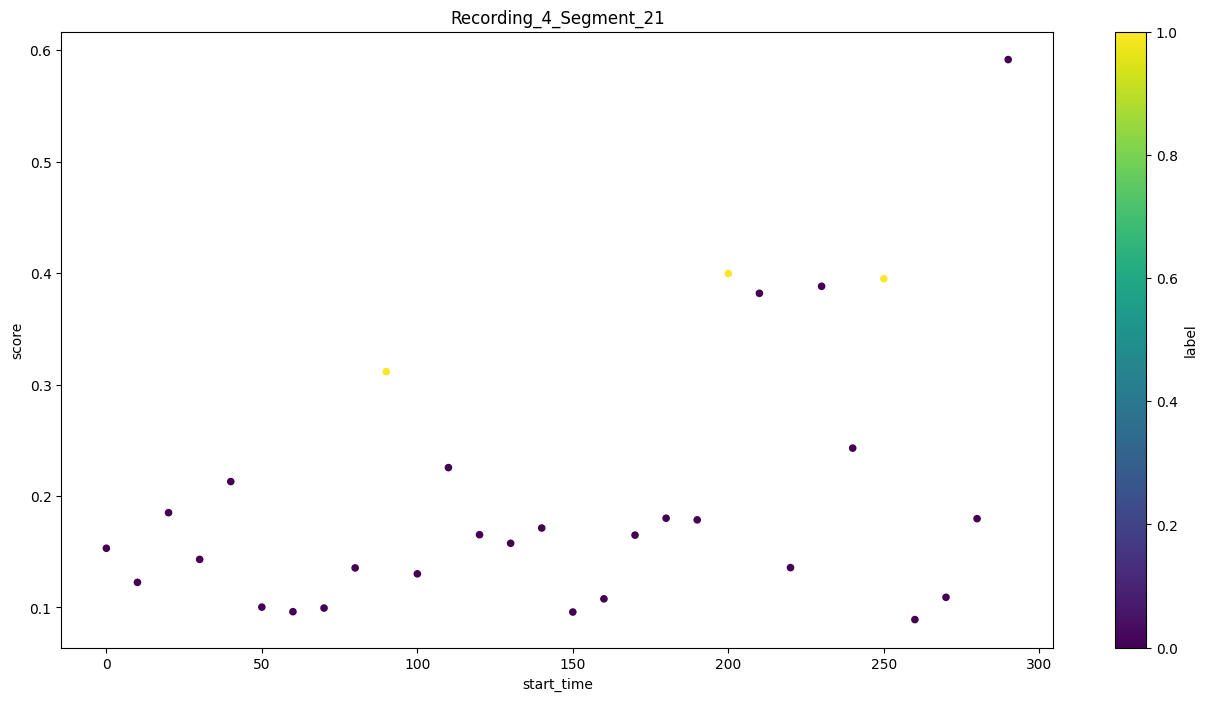

In [16]:
# Plots
results_df.reset_index(inplace=True)
for file in results_df['file'].unique():
    results_df[results_df['file']==file].plot.scatter(x='start_time', y='score', c='label', colormap='viridis', title=Path(file).stem)

On narrowing the `signal band` parameter, that is the frequency range it should look at, RIBBIT does slightly better on other clips too. Further analysis and updating of other parameters such as `noise bands` to remove unnecessary conflict might help it more.

### Wavelet method
This method employs the continuous wavelet transform.

#### Parameters
The parameters for this method are based on CWT arguments as given below.

In [19]:
sr = 40000 # resample audio to this sample rate
window_len = 4 # sec to analyze in one chunk
center_frequency = 3000 # target audio frequency of cwt
wavelet = 'morl' # pywt wavelet name - let's keep default for now
peak_threshold = 0.02 # height threhsold (0-1) for peaks in normalized signal
peak_separation = 1/15 # min duration (sec) between peaks
dt_range = (1/15, 1/2) # range of peak separation (sec) to search for
dy_range = (-0.5, 0.5) # range of peak separation reduction rate
d2y_range = (-0.5, 0.5) # range of peak separation reduction rate of change
max_skip = 3 # max sequential invalid points
duration_range = (2, 10) # length (sec) of sequence
points_range = (2, 150) # number of points in sequence
show_plots = True # show plots of each segment

#### Run + Analysis
Again, we analyze the single xeno-canto file with parameters set for the same.

detected peaks and sequences for window 1


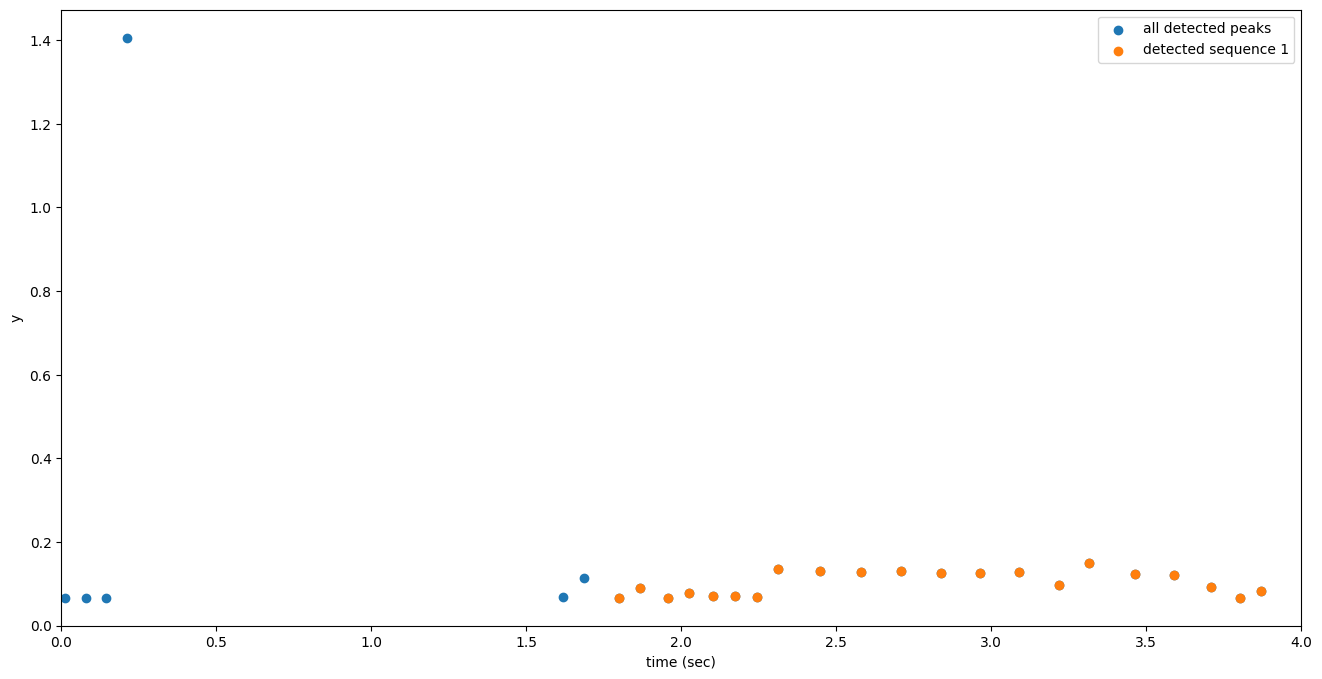

detected peaks and sequences for window 2


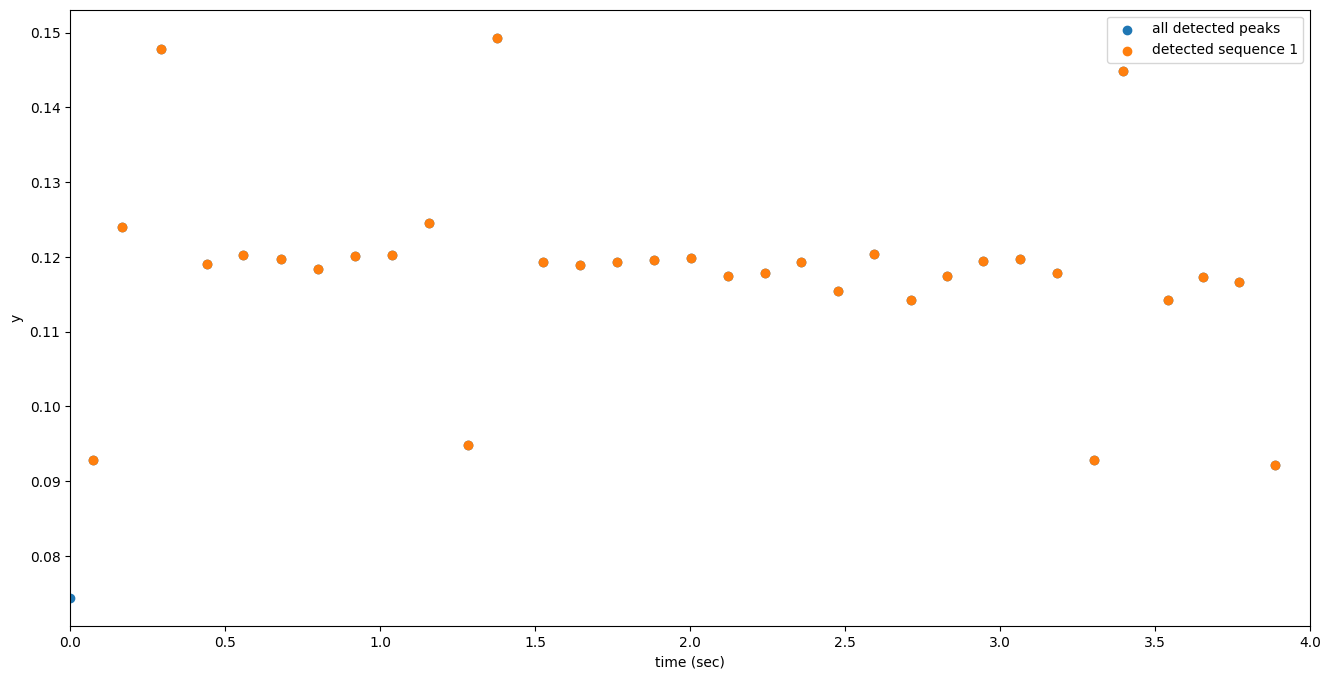

detected peaks and sequences for window 3


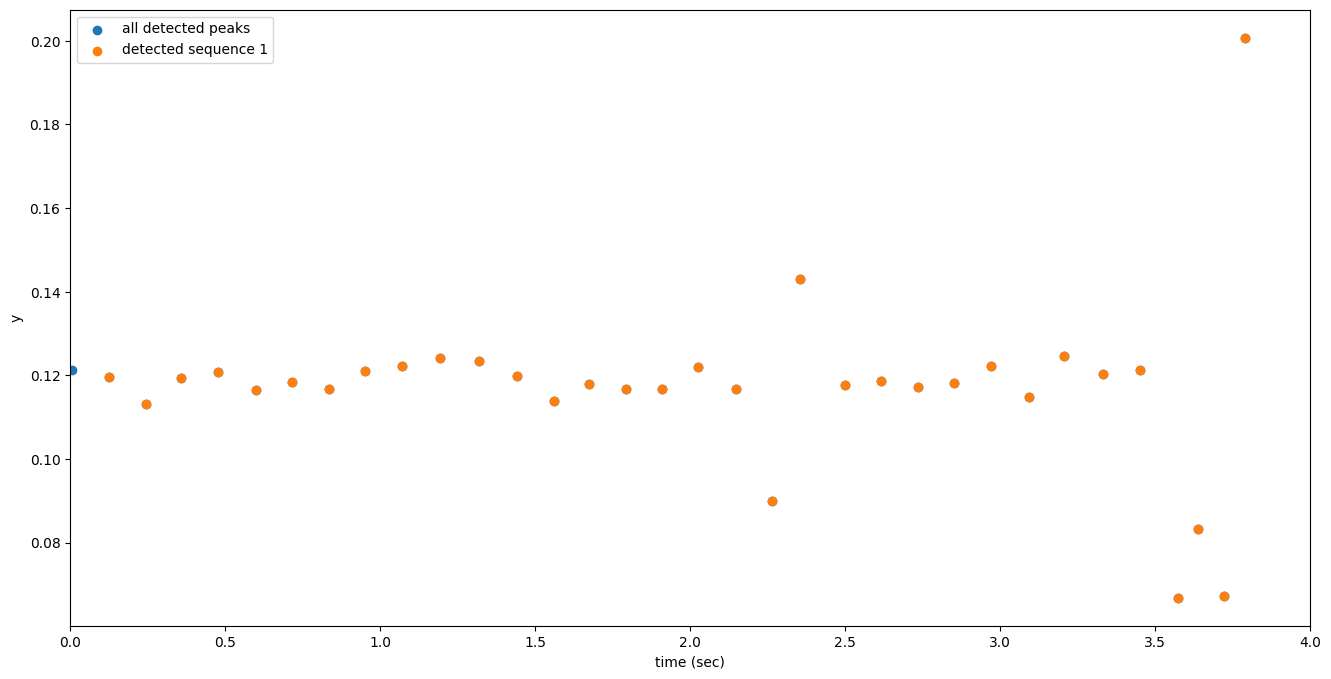

sequence_y  \
0  [0.06675041719010744, 0.09105056906605657, 0.0...   
1  [0.09282558015987599, 0.12405077531734574, 0.1...   
2  [0.119500746879668, 0.1132007075044219, 0.1193...   

                                          sequence_t  window_start_t  seq_len  \
0  [1.7997612485078032, 1.8665116656979106, 1.957...               0       21   
1  [4.0752504703154395, 4.168076050475316, 4.2921...               4       33   
2  [8.125800786254914, 8.245301533134581, 8.35850...               8       33   

   seq_start_time  seq_end_time  seq_midpoint_time  
0        1.799761      3.870399            2.83508  
1        4.075250      7.888149            5.98170  
2        8.125801     11.790399            9.95810

In [20]:
# run wavelet method
results_df = detect_peak_sequence_cwt(
                                            audio=nofl_keek_audio_xc,
                                            sample_rate=sr,
                                            window_len=window_len,
                                            center_frequency=center_frequency,
                                            wavelet=wavelet,
                                            peak_threshold=peak_threshold,
                                            peak_separation=peak_separation,
                                            dt_range=dt_range,
                                            dy_range=dy_range,
                                            d2y_range=d2y_range,
                                            max_skip=max_skip,
                                            duration_range=duration_range,
                                            points_range=points_range,
                                            plot=show_plots,
                                        )
results_df

This method works well on the xeno-canto clip too. Let us see its performance on the actual field set.

#### Evaluation

In [21]:
sr = 8400 # resample audio to this sample rate
window_len = 10 # sec to analyze in one chunk
show_plots = False # show plots of each segment

In [22]:
for file in nofl_keek_labels_df['file'].unique():

    all_results = []
    results_df = detect_peak_sequence_cwt(
                                                audio=Audio.from_file(file),
                                                sample_rate=sr,
                                                window_len=window_len,
                                                center_frequency=center_frequency,
                                                wavelet=wavelet,
                                                peak_threshold=peak_threshold,
                                                peak_separation=peak_separation,
                                                dt_range=dt_range,
                                                dy_range=dy_range,
                                                d2y_range=d2y_range,
                                                max_skip=max_skip,
                                                duration_range=duration_range,
                                                points_range=points_range,
                                                plot=show_plots,
                                            )
    if len(results_df)>0:
        results_df['file'] = file
        results_df.set_index('file', inplace=True)
        all_results.append(results_df)
    
all_results_df = pd.concat(all_results)
all_results_df

sequence_y  \
file                                                                                         
./data/clips/Recording_4_Segment_21.mp3  [0.06904844105286968, 0.12226336027809853, 0.0...   
./data/clips/Recording_4_Segment_21.mp3  [0.10309646543411233, 0.08785818878796176, 0.1...   
./data/clips/Recording_4_Segment_21.mp3  [0.08083429564637674, 0.07892951106560792, 0.0...   
./data/clips/Recording_4_Segment_21.mp3  [0.06964368623435993, 0.07511994190407029, 0.1...   
./data/clips/Recording_4_Segment_21.mp3  [0.21607400088096274, 0.12595388040333777, 0.1...   
./data/clips/Recording_4_Segment_21.mp3  [0.06892939201657161, 0.11440612388242719, 0.1...   
./data/clips/Recording_4_Segment_21.mp3  [0.07642948130334885, 0.07142942177883069, 0.0...   
./data/clips/Recording_4_Segment_21.mp3  [0.12881105727449138, 0.40845724353861357, 0.2...   
./data/clips/Recording_4_Segment_21.mp3  [0.3590518934749225, 0.1282158120930008, 0.067...   
./data/clips/Recording_4_Segment_21.mp3  [0.06904844105286967, 0.09047726758651889, 0.1...   
./data/clips/Recording_4_Segment_21.mp3  [0.07297705925070536, 0.07654853033964687, 0.1...   
./data/clips/Recording_4_Segment_21.mp3  [0.09988214145406493, 0.06857224490767744, 0.0...   
./data/clips/Recording_4_Segment_21.mp3  [0.38952844676722354, 0.06797699972618698, 0.0...   
./data/clips/Recording_4_Segment_21.mp3  [0.06666746032690865, 0.10333456350670844, 0.0...   
./data/clips/Recording_4_Segment_21.mp3  [0.11345373159204278, 0.07464374575887808, 0.0...   
./data/clips/Recording_4_Segment_21.mp3  [0.11262038833795641, 0.08547720806200071, 0.0...   
./data/clips/Recording_4_Segment_21.mp3  [0.07464374575887778, 0.09250110120358546, 0.1...   
./data/clips/Recording_4_Segment_21.mp3  [0.06761985261729306, 0.21714544220764534, 0.1...   
./data/clips/Recording_4_Segment_21.mp3  [0.10047738663555528, 0.10666793652305362, 0.2...   
./data/clips/Recording_4_Segment_21.mp3  [0.08297717829974172, 0.1333349206538177, 0.06...   
./data/clips/Recording_4_Segment_21.mp3  [0.11214419219276421, 0.10119168085334351, 0.1...   
./data/clips/Recording_4_Segment_21.mp3  [0.07357230443219562, 0.0833343254086358, 0.15...   
./data/clips/Recording_4_Segment_21.mp3  [0.12857295920189582, 0.07119132370623404, 0.0...   
./data/clips/Recording_4_Segment_21.mp3  [0.07083417659734045, 0.06738175454469694, 0.1...   
./data/clips/Recording_4_Segment_21.mp3  [0.11952523244324337, 0.10083453374444937, 0.0...   
./data/clips/Recording_4_Segment_21.mp3  [0.07357230443219562, 0.10797747592233245, 0.0...   
./data/clips/Recording_4_Segment_21.mp3  [0.07452469672258002, 0.0876200907153657, 0.12...   

                                                                                sequence_t  \
file                                                                                         
./data/clips/Recording_4_Segment_21.mp3  [0.0804771485374826, 0.14952558959035228, 0.27...   
./data/clips/Recording_4_Segment_21.mp3  [10.074167549613685, 10.177264015047799, 10.26...   
./data/clips/Recording_4_Segment_21.mp3  [20.077381873593733, 20.15821616924011, 20.237...   
./data/clips/Recording_4_Segment_21.mp3  [30.127977714020403, 30.197621400254764, 30.27...   
./data/clips/Recording_4_Segment_21.mp3  [44.652674436600435, 44.8687484374814, 44.9947...   
./data/clips/Recording_4_Segment_21.mp3  [60.14404933392064, 60.21297872593721, 60.3273...   
./data/clips/Recording_4_Segment_21.mp3  [70.0977392588007, 70.17416874010405, 70.24559...   
./data/clips/Recording_4_Segment_21.mp3  [91.48811295372563, 91.61692401100014, 92.0253...   
./data/clips/Recording_4_Segment_21.mp3  [96.13697782116454, 96.49602971463946, 96.6242...   
./data/clips/Recording_4_Segment_21.mp3  [130.15476374718747, 130.22381218824034, 130.3...   
./data/clips/Recording_4_Segment_21.mp3  [140.38107596519006, 140.45405302444075, 140.5...   
./data/clips/Recording_4_Segment_21.mp3  [150.30881320015715, 150.4086953416112, 150.47...   
./data/clips/Recording_4_Segment_21.m

Note: Detects sequences only from one of the segments and incorrectly.